In [1]:
import pandas as pd
import numpy as np
import random

# 1. Configuramos los parámetros de nuestra siderúrgica
n_registros = 100  # Vamos a simular 100 turnos de producción
maquinas = ['Laminadora-A', 'Laminadora-B', 'Prensa-H1']

data = {
    'Fecha': pd.date_range(start='2026-01-01', periods=n_registros, freq='D'),
    'Maquina': [random.choice(maquinas) for _ in range(n_registros)],
    'Tiempo_Total_Minutos': 480, # Turno de 8 horas
    'Tiempo_Parada_Minutos': [random.randint(20, 120) for _ in range(n_registros)], # Fallas técnicas
    'Piezas_Producidas': [random.randint(400, 500) for _ in range(n_registros)],
    'Piezas_Defectuosas': [random.randint(0, 30) for _ in range(n_registros)]
}

# 2. Creamos el archivo (DataFrame)
df = pd.DataFrame(data)

# 3. "Ensuciamos" los datos un poco para que practiques limpieza (Data Cleaning)
df.iloc[0, 1] = np.nan  # Borramos una máquina
df.iloc[5, 4] = -10     # Ponemos una producción imposible

# 4. Guardamos el archivo
df.to_csv('datos_siderurgia.csv', index=False)
print("¡Archivo 'datos_siderurgia.csv' creado con éxito!")


¡Archivo 'datos_siderurgia.csv' creado con éxito!


In [2]:
# 1. Leemos el archivo que creamos antes
df_limpio = pd.read_csv('datos_siderurgia.csv')

# 2. Verificamos cuántos errores hay
print("Errores detectados:")
print(df_limpio.isnull().sum()) # Esto nos dice si faltan datos

# 3. Limpieza:
# A la máquina que no tiene nombre, le pondremos 'Desconocida'
df_limpio['Maquina'] = df_limpio['Maquina'].fillna('Desconocida')

# A la producción negativa, la convertiremos en 0 (un error de sensor)
df_limpio.loc[df_limpio['Piezas_Producidas'] < 0, 'Piezas_Producidas'] = 0

print("\n--- ¡Datos Curados! ---")
print(df_limpio.head(10)) # Mostramos las primeras 10 filas

Errores detectados:
Fecha                    0
Maquina                  1
Tiempo_Total_Minutos     0
Tiempo_Parada_Minutos    0
Piezas_Producidas        0
Piezas_Defectuosas       0
dtype: int64

--- ¡Datos Curados! ---
        Fecha       Maquina  Tiempo_Total_Minutos  Tiempo_Parada_Minutos  \
0  2026-01-01   Desconocida                   480                     60   
1  2026-01-02     Prensa-H1                   480                     26   
2  2026-01-03  Laminadora-B                   480                     88   
3  2026-01-04  Laminadora-A                   480                     76   
4  2026-01-05  Laminadora-B                   480                     69   
5  2026-01-06  Laminadora-A                   480                    113   
6  2026-01-07  Laminadora-A                   480                     83   
7  2026-01-08  Laminadora-B                   480                     59   
8  2026-01-09  Laminadora-B                   480                     39   
9  2026-01-10     Pr

In [3]:
# 1. Calculamos la Disponibilidad (¿Cuánto tiempo estuvo encendida la máquina?)
# Si el turno es de 480 min, restamos las paradas y dividimos por el total.
df_limpio['Disponibilidad'] = (df_limpio['Tiempo_Total_Minutos'] - df_limpio['Tiempo_Parada_Minutos']) / df_limpio['Tiempo_Total_Minutos']

# 2. Calculamos la Calidad (¿Qué porcentaje de piezas salió bien?)
# (Piezas Totales - Defectuosas) dividido por Totales
df_limpio['Calidad'] = (df_limpio['Piezas_Producidas'] - df_limpio['Piezas_Defectuosas']) / df_limpio['Piezas_Producidas']

# 3. Calculamos el OEE Final
# OEE = Disponibilidad x Rendimiento x Calidad
# (Para este ejercicio simplificado, usaremos Disp x Calidad)
df_limpio['OEE'] = df_limpio['Disponibilidad'] * df_limpio['Calidad']

# 4. Ver el resultado final (los primeros 5 turnos)
print("Reporte de Eficiencia (OEE):")
print(df_limpio[['Maquina', 'Disponibilidad', 'Calidad', 'OEE']].head())

Reporte de Eficiencia (OEE):
        Maquina  Disponibilidad   Calidad       OEE
0   Desconocida        0.875000  0.948164  0.829644
1     Prensa-H1        0.945833  0.978313  0.925321
2  Laminadora-B        0.816667  0.955128  0.780021
3  Laminadora-A        0.841667  0.944330  0.794811
4  Laminadora-B        0.856250  0.942922  0.807377


In [4]:
# 1. Agrupamos por Máquina y calculamos el promedio (mean) de sus indicadores
ranking_maquinas = df_limpio.groupby('Maquina')[['Disponibilidad', 'Calidad', 'OEE']].mean()

# 2. Ordenamos de menor a mayor OEE para ver cuál falla más
ranking_maquinas = ranking_maquinas.sort_values(by='OEE', ascending=True)

print("--- RANKING DE EFICIENCIA POR MÁQUINA ---")
print(ranking_maquinas)

--- RANKING DE EFICIENCIA POR MÁQUINA ---
              Disponibilidad   Calidad       OEE
Maquina                                         
Laminadora-A        0.830013      -inf      -inf
Prensa-H1           0.850123  0.969426  0.824102
Desconocida         0.875000  0.948164  0.829644
Laminadora-B        0.860795  0.968644  0.833828


In [5]:
# 1. Reemplazamos los infinitos (-inf o inf) por 0 para que no arruinen el promedio
ranking_maquinas = ranking_maquinas.replace([np.inf, -np.inf], 0)

# 2. Mostramos de nuevo el ranking limpio
print("--- RANKING DE EFICIENCIA CORREGIDO ---")
print(ranking_maquinas)

--- RANKING DE EFICIENCIA CORREGIDO ---
              Disponibilidad   Calidad       OEE
Maquina                                         
Laminadora-A        0.830013  0.000000  0.000000
Prensa-H1           0.850123  0.969426  0.824102
Desconocida         0.875000  0.948164  0.829644
Laminadora-B        0.860795  0.968644  0.833828


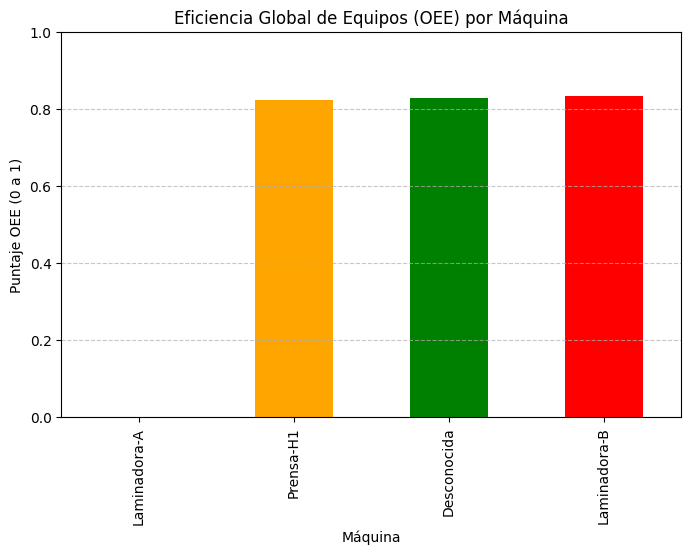

In [6]:
import matplotlib.pyplot as plt

# Crear el gráfico de barras del OEE por Máquina
ranking_maquinas['OEE'].plot(kind='bar', color=['red', 'orange', 'green'], figsize=(8, 5))

# Configurar títulos
plt.title('Eficiencia Global de Equipos (OEE) por Máquina')
plt.xlabel('Máquina')
plt.ylabel('Puntaje OEE (0 a 1)')
plt.ylim(0, 1) # El OEE siempre va de 0 a 1
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()